In [1]:
import PyPDF2
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
# Extract text from PDF file
def extract_text_from_pdf(file_path):
    pdf_file = PyPDF2.PdfReader(file_path)
    text = ''
    for page in range(len(pdf_file.pages)):
        text += pdf_file.pages[page].extract_text()
    return text

# Pre-process the data
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

# Extract keywords from text
def extract_keywords(text, ratio_threshold=90):
    words = text.split()
    keywords = []
    for word in words:
        if fuzz.token_set_ratio(word, text) >= ratio_threshold:
            keywords.append(word)
    return keywords



In [75]:
# Replace resume.pdf with your resume
resume_keywords = extract_keywords(preprocess_text(extract_text_from_pdf('resume.pdf')[100:]))
# 100: was added to skip the header section, optional

In [76]:
import requests
from bs4 import BeautifulSoup
import json

# Define the job post URL
url = 'https://www.linkedin.com/jobs/view/3455716295/?refId=d086dd12-f5e5-49c6-b79a-7df46fb86e70&trackingId=GFMyL8YCTJmGoBmgxVlaHA%3D%3D'

# Send a request to the URL
response = requests.get(url)


soup = BeautifulSoup(response.content, 'html.parser')


# Find the script tag with the JSON-LD data
job_post_script = soup.find('script', {'type': 'application/ld+json'})

# Extract the text from the script tag and load it as JSON
job_post_data = json.loads(job_post_script.text)

# Extract the description from the JSON data
job_post = job_post_data['description']



In [77]:
# IDENTIFY A GOOD STARTING AND ENDING POINT TO THE JOB DESCRIPTION #
job_post

'&lt;p&gt;&lt;strong&gt;Clinical Data Scientist / Clinical Informaticist&lt;/strong&gt;&lt;/p&gt;&lt;p&gt;New York or Remote / Full-Time / Early to Mid-Career / Early to Mid-2023 Start&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;p&gt;Resumes, questions, and requests for assistance or an accommodation due to a disability may be directed to Dandelion’s Director of Clinical Informatics, mara@dandelionhealth.ai.&amp;nbsp;&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;p&gt;References are required.&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;p&gt;&lt;strong&gt;Salary Range:&lt;/strong&gt; $150K - $175K + equity&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;p&gt;&lt;strong&gt;Our Team&lt;/strong&gt;&lt;/p&gt;&lt;p&gt;Dandelion Health was founded in 2020 by experts in health tech, hospital systems, academia, and clinical AI. We are building the world’s largest AI training and validation platform. Today, we pride ourselves on our ability to make data access as easy as possible for AI developers, while rais

In [78]:
print(re.search(r'\b(Your Role)\b', job_post))

<re.Match object; span=(2657, 2666), match='Your Role'>


In [79]:
job_post = job_post[2657:]

In [80]:
# EXTRACTING KEYWORDS FROM MODIFIED DESCRIPTION
job_post_text = preprocess_text(job_post)
job_post_keywords = extract_keywords(job_post_text)

<AxesSubplot:ylabel='Frequency'>

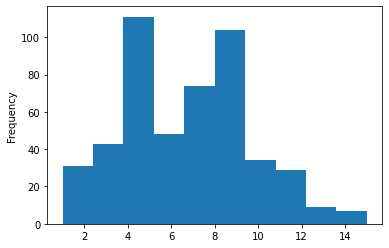

In [81]:
# Under 5 is likely not a main keyword: job post
pd.Series(list(dict.fromkeys(job_post_keywords))).str.len().plot(kind = 'hist')

In [82]:
# Removing duplicates from keyword
job_post_keywords = list(filter(lambda x: len(x)>=5, list(dict.fromkeys(job_post_keywords))))

<AxesSubplot:ylabel='Frequency'>

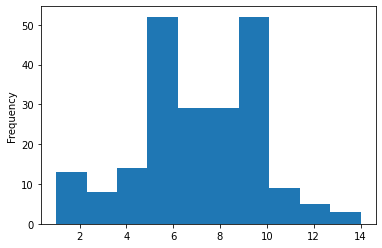

In [83]:
# Under 5 is likely not a main keyword: resume
pd.Series(list(dict.fromkeys(resume_keywords))).str.len().plot(kind = 'hist')

In [84]:
# Removing duplicates from keyword
resume_keywords = list(filter(lambda x: len(x)>=5, list(dict.fromkeys(resume_keywords))))

In [85]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Calculate cosine similarity between two keyword sets
def calculate_cosine_similarity(keywords1, keywords2):
    keywords1 = [word for word in keywords1 if word not in (stop)]
    keywords2 = [word for word in keywords2 if word not in (stop)]
    keywords1 = ' '.join(keywords1)
    keywords2 = ' '.join(keywords2)
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([keywords1, keywords2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)[0][1]

cosine_similarity_score = calculate_cosine_similarity(resume_keywords, job_post_keywords)

print('Cosine similarity score:', cosine_similarity_score)

THRESHOLD = 0.5

if cosine_similarity_score >= THRESHOLD:
    print("Your resume is a good match for the job post.")
else:
    print("Your resume is not a good match for the job post.")

Cosine similarity score: 0.09045576076054923
Your resume is not a good match for the job post.


In [86]:
import pandas as pd

keyword_df = pd.DataFrame({'Job Post Keyword': job_post_keywords})
keyword_df['Matched Resume Keyword'] = keyword_df['Job Post Keyword'].apply(lambda x: x if x in resume_keywords else float('nan'))

In [87]:
keyword_df

,Job Post Keyword,Matched Resume Keyword
0,strong,NaN
1,residency,NaN
2,trained,NaN
3,physician,NaN
4,knows,NaN
...,...,...
356,issues,NaN
357,collaboratively,NaN
358,dandelion,NaN
359,mission,NaN


In [81]:
import Levenshtein

# Calculate levenshtein distance between two keyword sets
def calculate_levenshtein_distance(keywords1, keywords2, threshold=0.75):
    keywords1 = [word for word in keywords1 if len(word) >= 4]
    keywords2 = [word for word in keywords2 if len(word) >= 4]
    matching_keywords = []
    for keyword1 in keywords1:
        for keyword2 in keywords2:
            distance = Levenshtein.distance(keyword1, keyword2)
            length = max(len(keyword1), len(keyword2))
            similarity = 1 - (distance / length)
            if similarity >= threshold:
                matching_keywords.append((keyword1, keyword2))
    return matching_keywords

matched_keywords = calculate_levenshtein_distance(resume_keywords, job_post_keywords)


lev_match_df = pd.DataFrame(matched_keywords, columns=['Resume Keyword', 'Job Post Keyword'])

In [82]:
lev_match_df

,Resume Keyword,Job Post Keyword
0,yoon,soon
1,health,health
2,health,health
3,health,health
4,health,health
...,...,...
745,certification,certification
746,valuation,validation
747,valuation,validation
748,management,management


In [77]:
job_post_keywords

['lt',
 'p',
 'gt',
 'lt',
 'strong',
 'gt',
 'clinical',
 'data',
 'scientist',
 'clinical',
 'informaticist',
 'lt',
 'strong',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'new',
 'york',
 'or',
 'remote',
 'full',
 'time',
 'early',
 'to',
 'mid',
 'career',
 'early',
 'to',
 'mid',
 'start',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'br',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'resumes',
 'questions',
 'and',
 'requests',
 'for',
 'assistance',
 'or',
 'an',
 'accommodation',
 'due',
 'to',
 'a',
 'disability',
 'may',
 'be',
 'directed',
 'to',
 'dandelion',
 's',
 'director',
 'of',
 'clinical',
 'informatics',
 'mara',
 'dandelionhealth',
 'ai',
 'amp',
 'nbsp',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'br',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'references',
 'are',
 'required',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'br',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'p',
 'gt',
 'lt',
 'strong',
 'gt',
 'salary',
 'range',
 'lt',
 'strong',
 